<a href="https://colab.research.google.com/github/pallavikhadse/Stock-Prediction-with-LSTM-RNN-using-Keras/blob/master/Stock_price_prediction_using_LSTM_for_3_years.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM Model with 3 years of Stock data of Google, Amazon and Apple. Timestep of 60 days. Multivariate features - Open prices of Google, Amazon and Apple. Data splitted into 60%-40% Training and Testing respectively. Validation data of 10% of Training data considered.

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
!pip install yfinance

## Getting the tickers (symbols) of few companies in S&P 500 from wikipedia website and saving to a file

In [3]:
import bs4 as bs    # bs4 is a Python library called BeautifulSoup4, used for pulling data out of HTML & XML files.
import requests     # requests is a Python module, used for sending HTTP request. The HTTP request returns a Response object with all the data like (content, encoding, status, etc)
import pickle       # pickle is a Python module, used for serializing & de-serializing a object structure.

In [4]:
def fetch_tickers_wikipedia():
    response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(response.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})       # Searching table in wikipedia with class-wikitable sortable
    
    tickers = []
    
    for row in table.findAll('tr')[20:50]:          # tr is row of the table and from row 1 is considered, row 0 is Header which is avoided
        ticker = row.findAll('td')[0].get_text(strip = True).replace('.', '-')       # td is column of the table and 0 is the first column
        tickers.append(ticker)
        fileName = "tickers_snp500_3years.pickle"
        fileObject = open(fileName, 'wb')       # wb for writing into file
    with fileObject as f:
        pickle.dump(tickers, f)                 # writing into tickers_snp500 file
    return tickers

fetch_tickers_wikipedia()

['ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM']

## fetching historical stock of above fetched tickers of s&p 500 from Yahoo finance

In [5]:
import os
import datetime as dt
import yfinance as yf
import pandas as pd


def fetch_snp500_yahoo():
    with open("tickers_snp500_3years.pickle", "rb") as f:    # Command Open "tickers_snp500.pickle" to read
        tickers = pickle.load(f)
        
    if not os.path.exists('snp500_folder_3years'):     # If folder snp500_folder does not exit, then make a new folder
        os.makedirs('snp500_folder_3years')
        
    for ticker in tickers:
        print(ticker)        
        stockData = 'snp500_folder_3years/{}.csv'.format(ticker)         # convert above data to csv and save in folder snp500_folder
        f = open(stockData, 'w')                                  # Command Open to write
        ticker = yf.Ticker(ticker)
        df = ticker.history(start = "2017-12-31", end = "2020-12-31")     # Read ticker stock from yahoo with the given dates
        f.write(df.to_csv())
        f.close()
        
        
fetch_snp500_yahoo()  

ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
ANTM
AON
AOS
APA
AAPL
AMAT
APTV
ADM


# Reading data of our targeted stock - Google

In [6]:
googl_df = pd.read_csv('/content/snp500_folder_3years/GOOGL.csv', parse_dates=['Date'])
googl_df.tail

<bound method NDFrame.tail of           Date         Open         High  ...   Volume  Dividends  Stock Splits
0   2018-01-02  1053.020020  1075.979980  ...  1588300          0             0
1   2018-01-03  1073.930054  1096.099976  ...  1565900          0             0
2   2018-01-04  1097.089966  1104.079956  ...  1302600          0             0
3   2018-01-05  1103.449951  1113.579956  ...  1512500          0             0
4   2018-01-08  1111.000000  1119.160034  ...  1232200          0             0
..         ...          ...          ...  ...      ...        ...           ...
750 2020-12-23  1723.930054  1744.109985  ...  1148700          0             0
751 2020-12-24  1729.000000  1742.410034  ...   465600          0             0
752 2020-12-28  1744.910034  1787.000000  ...  1382500          0             0
753 2020-12-29  1787.229980  1788.469971  ...   986300          0             0
754 2020-12-30  1765.000000  1767.760010  ...  1051300          0             0

[755 rows

In [7]:
googl_df = googl_df.drop(columns = ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])        # Dropping two columns which are not required

In [8]:
googl_df = googl_df.set_index('Date')           # Making Date column to index
googl_df = googl_df.rename(columns = {'Open': 'Open_GOOGL'})
googl_df

,Open_GOOGL
Date,
2018-01-02,1053.020020
2018-01-03,1073.930054
2018-01-04,1097.089966
2018-01-05,1103.449951
2018-01-08,1111.000000
...,...
2020-12-23,1723.930054
2020-12-24,1729.000000
2020-12-28,1744.910034


## Combining column 'Open' of above companies from s&p500 


In [9]:
def combine_data():
    data_tickers = pd.DataFrame()
    with open("tickers_snp500_3years.pickle", "rb") as f:
        tickers = pickle.load(f)
    
    for count, ticker in enumerate(tickers):
        if 'GOOGL' in ticker:                # If GOOGL is present in tickers pickle file list then continue
            continue
        if not os.path.exists('snp500_folder_3years/{}.csv'.format(ticker)):     # If format(ticker) is not equal to format(GOOGL) then continue 
            continue                                                      # We continue because we want all tickers except GOOGL
        data_ticker = pd.read_csv('snp500_folder_3years/{}.csv'.format(ticker))
        data_ticker = data_ticker.set_index('Date')
        data_ticker = data_ticker.drop(columns = ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
        #data_ticker = data_ticker.drop(columns=['High', 'Low', 'Volume'])
        #data_ticker = data_ticker.set_index('Date')                        # Read data of each ticker and change its index to column Date
        #data_ticker = data_ticker.rename(columns = {'Open': 'Open_'+ticker, 'Close': 'Close_'+ticker})
        data_ticker = data_ticker.rename(columns = {'Open': 'Open_'+ticker})
        if data_tickers.empty:
            data_tickers = data_ticker
        else:
            data_tickers = data_tickers.join(data_ticker, how = 'outer')                
        
    print(data_tickers)
       
    data_tickers.to_csv('Data_tickers_3years.csv')
                                        
combine_data()                                   

             Open_ALLE   Open_LNT    Open_ALL  ...  Open_AMAT   Open_APTV   Open_ADM
Date                                           ...                                  
2018-01-02   77.513882  38.647819   97.907843  ...  49.279915   83.393478  36.221815
2018-01-03   77.659092  38.112800   95.885160  ...  51.053542   84.572330  36.176767
2018-01-04   78.046312  37.759146   96.205032  ...  51.968954   86.389712  35.915465
2018-01-05   79.169283  37.523382   95.245403  ...  52.111993   88.216925  36.546196
2018-01-08   78.753019  37.251345   95.809895  ...  52.455271   90.869323  36.113691
...                ...        ...         ...  ...        ...         ...        ...
2020-12-23  112.779999  50.054741  106.430000  ...  86.300003  127.139999  48.679712
2020-12-24  113.040001  49.172066  106.190002  ...  84.739998  128.899994  49.067004
2020-12-28  113.489998  49.935729  108.019997  ...  86.370003  128.940002  49.454296
2020-12-29  115.190002  50.193591  107.730003  ...  85.019997  12

## Drop unwanted columns

In [10]:
Data_tickers = pd.read_csv('Data_tickers_3years.csv', parse_dates=['Date'])
Data_tickers = Data_tickers.set_index('Date')
Data_tickers_final = Data_tickers.drop(columns = ['Open_MO', 'Open_ALLE', 'Open_GOOG', 'Open_LNT', 'Open_ALL', 'Open_AMCR', 'Open_AEE', 'Open_AAL', 'Open_AEP', 'Open_AXP', 'Open_AIG', 'Open_AMT', 'Open_AWK', 'Open_AMP', 'Open_ABC', 'Open_AME', 'Open_AMGN', 'Open_APH', 'Open_ADI', 'Open_ANSS', 'Open_ANTM', 'Open_AON', 'Open_AOS', 'Open_APA', 'Open_AMAT', 'Open_APTV', 'Open_ADM'])
Data_tickers_final

,Open_AMZN,Open_AAPL
Date,,
2018-01-02,1172.000000,40.875778
2018-01-03,1188.300049,41.445098
2018-01-04,1205.000000,41.447507
2018-01-05,1217.510010,41.663710
2018-01-08,1236.000000,41.882305
...,...,...
2020-12-23,3205.000000,131.962809
2020-12-24,3193.899902,131.124063
2020-12-28,3194.000000,133.790085


## Concatenate Google with Amazon and Apple 

In [11]:
dataset_original = pd.concat([googl_df, Data_tickers_final], axis = 1, join = 'outer')
dataset_original

,Open_GOOGL,Open_AMZN,Open_AAPL
Date,,,
2018-01-02,1053.020020,1172.000000,40.875778
2018-01-03,1073.930054,1188.300049,41.445098
2018-01-04,1097.089966,1205.000000,41.447507
2018-01-05,1103.449951,1217.510010,41.663710
2018-01-08,1111.000000,1236.000000,41.882305
...,...,...,...
2020-12-23,1723.930054,3205.000000,131.962809
2020-12-24,1729.000000,3193.899902,131.124063
2020-12-28,1744.910034,3194.000000,133.790085


In [12]:
dataset_original.describe

<bound method NDFrame.describe of              Open_GOOGL    Open_AMZN   Open_AAPL
Date                                            
2018-01-02  1053.020020  1172.000000   40.875778
2018-01-03  1073.930054  1188.300049   41.445098
2018-01-04  1097.089966  1205.000000   41.447507
2018-01-05  1103.449951  1217.510010   41.663710
2018-01-08  1111.000000  1236.000000   41.882305
...                 ...          ...         ...
2020-12-23  1723.930054  3205.000000  131.962809
2020-12-24  1729.000000  3193.899902  131.124063
2020-12-28  1744.910034  3194.000000  133.790085
2020-12-29  1787.229980  3309.939941  137.844025
2020-12-30  1765.000000  3341.000000  135.377703

[755 rows x 3 columns]>

In [13]:
#dataset_original = dataset_original.drop(pd.Timestamp('31-12-2018'))

In [14]:
dataset_original.shape

(755, 3)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter
import seaborn as sns

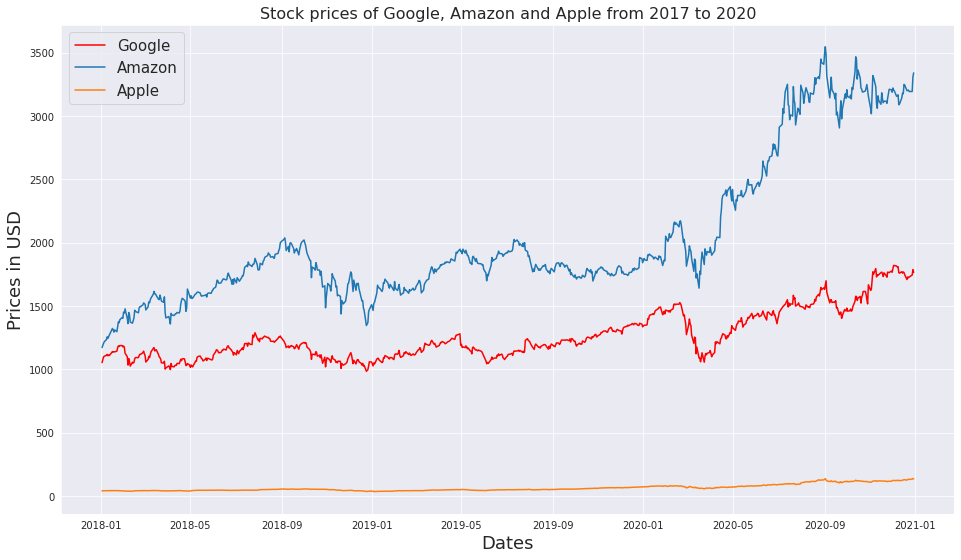

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,9))
plt.plot(dataset_original['Open_GOOGL'], color = 'red', label = 'Google')
plt.plot(dataset_original['Open_AMZN'], label = 'Amazon')
plt.plot(dataset_original['Open_AAPL'], label = 'Apple')
plt.title("Stock prices of Google, Amazon and Apple from 2017 to 2020", fontsize = 16)
plt.xlabel('Dates', fontsize = 18)
plt.xticks(x = 'Date', rotation = 0)
#plt.margins(0.2)
plt.ylabel('Prices in USD', fontsize = 18)
plt.legend(fontsize=15)
plt.show()

## Split dataset into training and testing

In [17]:
  # Splitting dataset into 60%-40%

training_size = int(len(dataset_original)*0.6)                # int for rounded value / whole number
testing_size = len(dataset_original)-training_size

training_size, testing_size

(453, 302)

In [18]:
training_data = dataset_original.iloc[0:training_size, :].values
testing_data = dataset_original.iloc[training_size:len(dataset_original), :].values

In [19]:
training_data, testing_data

(array([[1053.02001953, 1172.        ,   40.87577849],
        [1073.93005371, 1188.30004883,   41.44509825],
        [1097.08996582, 1205.        ,   41.44750709],
        ...,
        [1241.81005859, 1773.32995605,   57.5837794 ],
        [1251.40002441, 1796.48999023,   58.00818227],
        [1254.68994141, 1787.80004883,   57.88481571]]),
 array([[1248.69995117, 1769.66003418,   58.60778536],
        [1244.47998047, 1788.15002441,   59.50595582],
        [1240.20996094, 1761.30004883,   59.73789764],
        [1259.10998535, 1771.08996582,   60.33255536],
        [1252.        , 1697.55004883,   59.99945355],
        [1275.        , 1748.06005859,   61.05059514],
        [1276.        , 1774.81005859,   61.43306396],
        [1255.15002441, 1760.23999023,   60.39424742],
        [1260.        , 1775.98999023,   61.00618531],
        [1265.80004883, 1788.01000977,   61.57370853],
        [1276.10998535, 1801.01000977,   63.49587592],
        [1291.19995117, 1809.16003418,   63.426789

In [20]:
training_data.shape, testing_data.shape

((453, 3), (302, 3))

## Data preparation

In [21]:
# To normalise the data in (0, 1), MinMax scaler module is used

from sklearn.preprocessing import MinMaxScaler

In [22]:
sc = MinMaxScaler(feature_range = (0,1))
training_data_scaled = sc.fit_transform(training_data)
training_data_scaled

array([[0.22539375, 0.        , 0.24844865],
       [0.29399623, 0.01881984, 0.27296413],
       [0.36998019, 0.0381014 , 0.27306785],
       ...,
       [0.84478367, 0.69428822, 0.96791175],
       [0.87624681, 0.72102851, 0.98618696],
       [0.8870405 , 0.71099521, 0.98087468]])

In [23]:
training_data_scaled.shape

(453, 3)

In [24]:
len(training_data_scaled)  

453

In [25]:
# Timesteps considered = 60 days.

X_train = []
y_train = []

for i in range(60, len(training_data_scaled)):
    X_train.append(training_data_scaled[i-60:i, 0:])
    y_train.append(training_data_scaled[i, 0])

X_train, y_train

([array([[0.22539375, 0.        , 0.24844865],
         [0.29399623, 0.01881984, 0.27296413],
         [0.36998019, 0.0381014 , 0.27306785],
         [0.39084629, 0.0525453 , 0.28237776],
         [0.41561679, 0.07389362, 0.29179069],
         [0.44002605, 0.09802453, 0.29385976],
         [0.40249343, 0.08445812, 0.27948121],
         [0.41991488, 0.10130352, 0.29427323],
         [0.41266395, 0.11706367, 0.31072007],
         [0.5117784 , 0.17434275, 0.32851219],
         [0.49881885, 0.16191938, 0.31040999],
         [0.50862853, 0.14080192, 0.34371819],
         [0.50429799, 0.16164229, 0.33585656],
         [0.52329378, 0.1445198 , 0.32230611],
         [0.61122046, 0.19176544, 0.32230587],
         [0.65833327, 0.23417343, 0.32178846],
         [0.64432402, 0.2262992 , 0.29344564],
         [0.66669957, 0.25402087, 0.2674821 ],
         [0.66824147, 0.27384519, 0.24844873],
         [0.63451434, 0.26690611, 0.20055563],
         [0.65449495, 0.32247642, 0.21441707],
         [0.6

In [26]:
# Convert to numpy array

import numpy as np

In [27]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train, y_train

(array([[[0.22539375, 0.        , 0.24844865],
         [0.29399623, 0.01881984, 0.27296413],
         [0.36998019, 0.0381014 , 0.27306785],
         ...,
         [0.21745397, 0.41334242, 0.23391801],
         [0.26108931, 0.46229697, 0.29218477],
         [0.05770986, 0.31751164, 0.22540125]],
 
        [[0.29399623, 0.01881984, 0.27296413],
         [0.36998019, 0.0381014 , 0.27306785],
         [0.39084629, 0.0525453 , 0.28237776],
         ...,
         [0.26108931, 0.46229697, 0.29218477],
         [0.05770986, 0.31751164, 0.22540125],
         [0.08822184, 0.27017354, 0.23121774]],
 
        [[0.36998019, 0.0381014 , 0.27306785],
         [0.39084629, 0.0525453 , 0.28237776],
         [0.41561679, 0.07389362, 0.29179069],
         ...,
         [0.05770986, 0.31751164, 0.22540125],
         [0.08822184, 0.27017354, 0.23121774],
         [0.14206033, 0.28358984, 0.21906584]],
 
        ...,
 
        [[0.52207989, 0.95136877, 0.69485292],
         [0.48654854, 0.92055289, 0.68649

In [28]:
# Reshaping in 3-dimension as LSTM requires 3-dimension feature
# Reshape input to 3-dimension [samples, timesteps, features]

#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))  
#X_train

In [29]:
X_train.shape, y_train.shape

((393, 60, 3), (393,))

## Building LSTM model

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [31]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 3)))
model.add(Dropout(0.2))                                         # Adding few dropout layers for preventing over-fitting. 0.2-->20% of the layer will be dropped
                                                                
model.add(LSTM(units = 110, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120))
model.add(Dropout(0.2))

model.add(Dense(units = 1))                  # The final dense layer's units should be equal to the number of features in your y_train. 

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           41600     
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 110)           92840     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 110)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 120)           110880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               1

In [33]:
history = model.fit(X_train, y_train, epochs = 250, batch_size = 32, validation_split = 0.1, shuffle = False, verbose = 1)

Epoch 1/250
12/12 [==============================] - 7s 143ms/step - loss: 0.1623 - val_loss: 0.3335
Epoch 2/250
12/12 [==============================] - 0s 19ms/step - loss: 0.0966 - val_loss: 0.0360
Epoch 3/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0465 - val_loss: 0.0140
Epoch 4/250
12/12 [==============================] - 0s 15ms/step - loss: 0.0421 - val_loss: 0.0577
Epoch 5/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0341 - val_loss: 0.0222
Epoch 6/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0294 - val_loss: 0.0235
Epoch 7/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0265 - val_loss: 0.0326
Epoch 8/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0231 - val_loss: 0.0413
Epoch 9/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0532
Epoch 10/250
12/12 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.072

## Plotting Train and Test losses during epochs

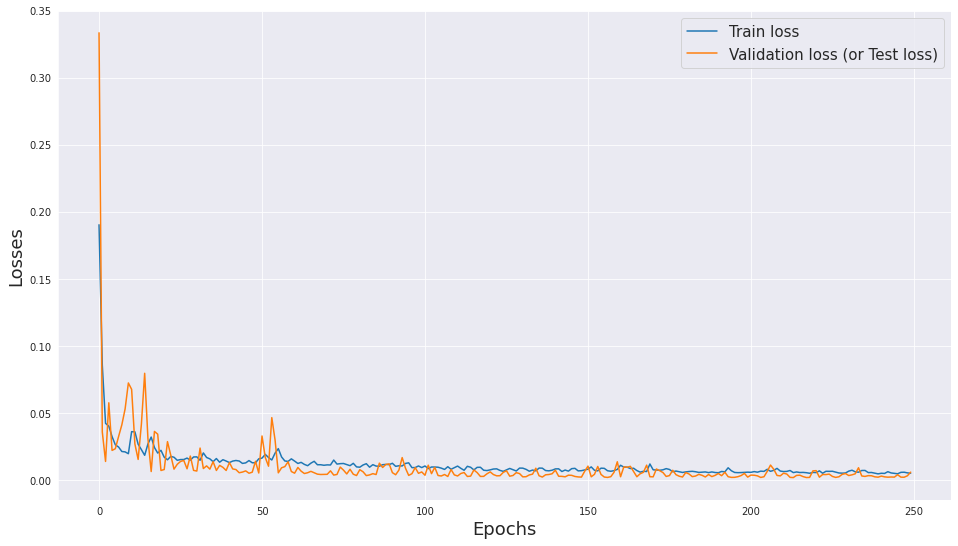

In [34]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,9))
plt.plot(history.history["loss"], label = 'Train loss')
plt.plot(history.history["val_loss"], label = 'Validation loss (or Test loss)')
plt.legend(fontsize=15)
plt.xlabel('Epochs', fontsize = 18)
plt.xticks(x = 'Epochs', rotation = 0)
#plt.margins(0.2)
plt.ylabel('Losses', fontsize = 18)
plt.show()

## Scaling the test data

##### Note: The train data and test data are scaled after splitting the main data. This is because scaling invokes the calculation of statistic, ie., minimun, mean, maximum of a variable. When performing a prediction of the real data, one do not have the future data at the time of prediction. Hence, calculations of the scaling statistics has to be performed on the training data first and then must be applied to the test data. Otherwise, one use the future data/ information at the time of predicting which commonly biases prediction metries in a positive direction.

In [35]:
# Concatenate the training and testing data values as we will need these to our timesteps of 60 days to get the stock price for each day

inputs = dataset_original[len(dataset_original) - len(testing_data) - 60:].values
inputs.shape

(362, 3)

In [36]:
type(inputs)

numpy.ndarray

In [37]:
#inputs = inputs.reshape(-1, 3)
inputs = sc.transform(inputs)
inputs

array([[0.79947507, 0.88903259, 0.68447967],
       [0.84704725, 0.87517753, 0.69485301],
       [0.79619423, 0.83028715, 0.69802849],
       ...,
       [2.4953742 , 2.33457648, 4.2494309 ],
       [2.63421918, 2.46843932, 4.4239976 ],
       [2.56128617, 2.50430088, 4.31779529]])

In [38]:
inputs.shape

(362, 3)

In [39]:
X_test = []
y_test = []

for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0:])
    y_test.append(inputs[i, 0])

X_test, y_test

([array([[0.79947507, 0.88903259, 0.68447967],
         [0.84704725, 0.87517753, 0.69485301],
         [0.79619423, 0.83028715, 0.69802849],
         [0.78920603, 0.83835771, 0.77910966],
         [0.76545278, 0.80788812, 0.75243539],
         [0.71745407, 0.77711833, 0.66383902],
         [0.61893035, 0.69069746, 0.58402793],
         [0.59448825, 0.71610995, 0.56624472],
         [0.56916026, 0.69505028, 0.55671844],
         [0.66309073, 0.73200865, 0.60742072],
         [0.70757871, 0.75850638, 0.62715994],
         [0.64199475, 0.72045121, 0.60930949],
         [0.62345793, 0.70545313, 0.6241849 ],
         [0.62910087, 0.71701056, 0.64692291],
         [0.60403561, 0.70428698, 0.65011038],
         [0.64458674, 0.71687202, 0.65882314],
         [0.68080695, 0.74595602, 0.72618739],
         [0.69235557, 0.74182264, 0.72894998],
         [0.69389747, 0.7474686 , 0.75136929],
         [0.6872705 , 0.75740958, 0.75349424],
         [0.65895684, 0.71703368, 0.71354315],
         [0.5

In [40]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test, y_test

(array([[[0.79947507, 0.88903259, 0.68447967],
         [0.84704725, 0.87517753, 0.69485301],
         [0.79619423, 0.83028715, 0.69802849],
         ...,
         [0.84478367, 0.69428822, 0.96791175],
         [0.87624681, 0.72102851, 0.98618696],
         [0.8870405 , 0.71099521, 0.98087468]],
 
        [[0.84704725, 0.87517753, 0.69485301],
         [0.79619423, 0.83028715, 0.69802849],
         [0.78920603, 0.83835771, 0.77910966],
         ...,
         [0.87624681, 0.72102851, 0.98618696],
         [0.8870405 , 0.71099521, 0.98087468],
         [0.8673883 , 0.69005097, 1.01200647]],
 
        [[0.79619423, 0.83028715, 0.69802849],
         [0.78920603, 0.83835771, 0.77910966],
         [0.76545278, 0.80788812, 0.75243539],
         ...,
         [0.8870405 , 0.71099521, 0.98087468],
         [0.8673883 , 0.69005097, 1.01200647],
         [0.85354325, 0.71139929, 1.05068258]],
 
        ...,
 
        [[1.63825475, 2.35074071, 3.53772216],
         [1.55941606, 2.28796564, 3.33383

In [41]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
#X_test

In [42]:
#X_test.shape

In [43]:
X_train.shape, y_train.shape

((393, 60, 3), (393,))

In [44]:
X_test.shape, y_test.shape

((302, 60, 3), (302,))

In [45]:
X_train[0][0].shape

(3,)

In [46]:
X_test[0][0].shape

(3,)

## Make a prediction

In [47]:
y_train_predict = model.predict(X_train)
y_train_predict

array([[0.11257061],
       [0.06797126],
       [0.07235648],
       [0.08880344],
       [0.08468731],
       [0.13295467],
       [0.16041991],
       [0.16127276],
       [0.16767734],
       [0.17692655],
       [0.18215258],
       [0.20175499],
       [0.21486798],
       [0.23783031],
       [0.2766349 ],
       [0.280508  ],
       [0.28944084],
       [0.2898185 ],
       [0.2538688 ],
       [0.19112648],
       [0.15703343],
       [0.1663599 ],
       [0.16855332],
       [0.14602639],
       [0.15449308],
       [0.16163796],
       [0.16029498],
       [0.20913735],
       [0.26430595],
       [0.2883997 ],
       [0.34137034],
       [0.37705114],
       [0.393929  ],
       [0.38163102],
       [0.35425207],
       [0.3361419 ],
       [0.307388  ],
       [0.30963373],
       [0.3329469 ],
       [0.31651425],
       [0.32450348],
       [0.33317855],
       [0.32106104],
       [0.30792648],
       [0.31407258],
       [0.3689575 ],
       [0.4476488 ],
       [0.509

In [48]:
y_train_predict.shape

(393, 1)

In [49]:
sc.scale_               # Here, inverse transform is not applicable as only one column of y_test is to be scaled. Inverse transform is used to scale a complete dataset

array([0.00328084, 0.00115459, 0.04306099])

In [50]:
scale = 1/0.00328084
scale

304.7999902464003

In [51]:
y_train_predict = y_train_predict*scale
y_train = y_train*scale


#y_test_predict = sc.inverse_transform(y_test_predict)

In [52]:
y_train_predict, y_train

(array([[ 34.311523],
        [ 20.71764 ],
        [ 22.054253],
        [ 27.067287],
        [ 25.81269 ],
        [ 40.524582],
        [ 48.89599 ],
        [ 49.155937],
        [ 51.10805 ],
        [ 53.92721 ],
        [ 55.520107],
        [ 61.49492 ],
        [ 65.49176 ],
        [ 72.49068 ],
        [ 84.31831 ],
        [ 85.49884 ],
        [ 88.221565],
        [ 88.33668 ],
        [ 77.3792  ],
        [ 58.25535 ],
        [ 47.86379 ],
        [ 50.706497],
        [ 51.37505 ],
        [ 44.508842],
        [ 47.08949 ],
        [ 49.26725 ],
        [ 48.857906],
        [ 63.74506 ],
        [ 80.56045 ],
        [ 87.90422 ],
        [104.049675],
        [114.925186],
        [120.06956 ],
        [116.32113 ],
        [107.97603 ],
        [102.456055],
        [ 93.691864],
        [ 94.37636 ],
        [101.48221 ],
        [ 96.47354 ],
        [ 98.90866 ],
        [101.55282 ],
        [ 97.859406],
        [ 93.85599 ],
        [ 95.72932 ],
        [1

In [53]:
# Predicting our dataset

y_test_predict = model.predict(X_test)
y_test_predict

array([[0.76953775],
       [0.77438194],
       [0.76706964],
       [0.7540517 ],
       [0.7624148 ],
       [0.7711525 ],
       [0.79955065],
       [0.8276343 ],
       [0.821336  ],
       [0.80659354],
       [0.79839563],
       [0.8046504 ],
       [0.8263112 ],
       [0.84404016],
       [0.8558726 ],
       [0.8668621 ],
       [0.87582165],
       [0.8762614 ],
       [0.8671642 ],
       [0.85792553],
       [0.8666763 ],
       [0.8956796 ],
       [0.91902703],
       [0.91676724],
       [0.89420563],
       [0.8714062 ],
       [0.8497121 ],
       [0.8410715 ],
       [0.8427784 ],
       [0.8406576 ],
       [0.83195424],
       [0.8067657 ],
       [0.7950583 ],
       [0.8101462 ],
       [0.8419922 ],
       [0.877751  ],
       [0.90630704],
       [0.9304512 ],
       [0.94388026],
       [0.9526895 ],
       [0.9628036 ],
       [0.9756468 ],
       [0.9810641 ],
       [0.9767089 ],
       [0.97596335],
       [0.97350615],
       [0.96463054],
       [0.951

In [54]:
y_test_predict.shape

(302, 1)

In [55]:
sc.scale_ 

array([0.00328084, 0.00115459, 0.04306099])

In [56]:
scale = 1/0.00328084
scale

304.7999902464003

In [57]:
y_test_predict = y_test_predict*scale
y_test = y_test*scale

In [58]:
y_test_predict, y_test

(array([[234.5551  ],
        [236.0316  ],
        [233.80281 ],
        [229.83495 ],
        [232.38403 ],
        [235.04727 ],
        [243.70303 ],
        [252.26292 ],
        [250.3432  ],
        [245.8497  ],
        [243.35098 ],
        [245.25745 ],
        [251.85963 ],
        [257.26343 ],
        [260.86993 ],
        [264.21957 ],
        [266.95044 ],
        [267.08447 ],
        [264.31165 ],
        [261.4957  ],
        [264.1629  ],
        [273.00314 ],
        [280.11942 ],
        [279.43063 ],
        [272.55386 ],
        [265.60458 ],
        [258.99222 ],
        [256.35858 ],
        [256.87885 ],
        [256.23242 ],
        [253.57964 ],
        [245.90216 ],
        [242.33377 ],
        [246.93256 ],
        [256.63922 ],
        [267.53848 ],
        [276.24237 ],
        [283.60153 ],
        [287.6947  ],
        [290.37976 ],
        [293.46252 ],
        [297.37714 ],
        [299.02832 ],
        [297.70087 ],
        [297.47363 ],
        [2

## Visualizing Stock prediction prices with actual Stock prices

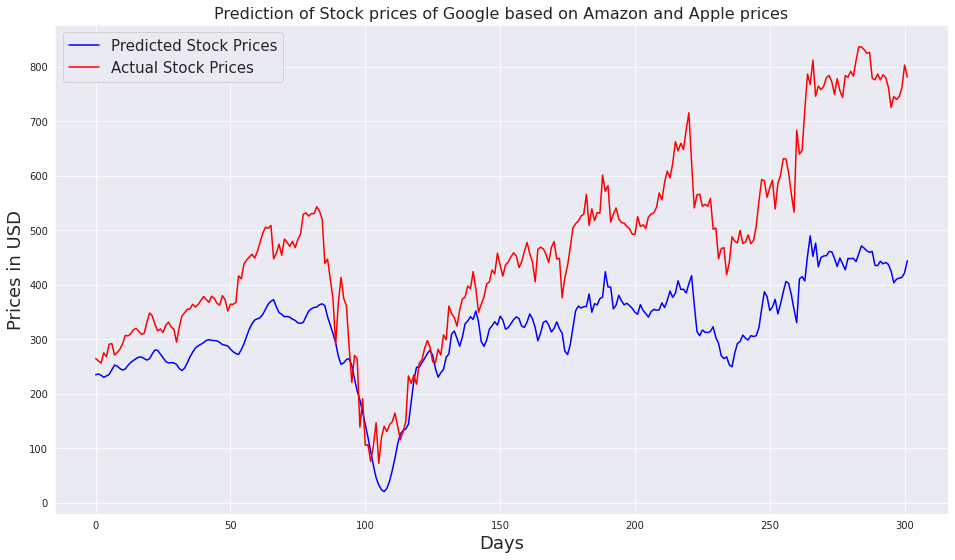

In [59]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,9))
plt.plot(y_test_predict, color = 'blue', label = 'Predicted Stock Prices')
plt.plot(y_test, color = 'red', label = 'Actual Stock Prices')
plt.title("Prediction of Stock prices of Google based on Amazon and Apple prices", fontsize = 16)
plt.xlabel('Days', fontsize = 18)
plt.xticks(x = 'Days', rotation = 0)
#plt.margins(0.2)
plt.ylabel('Prices in USD', fontsize = 18)
plt.legend(fontsize=15)
plt.show()

## Calculating RMSE performance metrics

In [60]:
import math
from sklearn.metrics import mean_squared_error

In [61]:
math.sqrt(mean_squared_error(y_train, y_train_predict))

20.18144736144569

In [62]:
math.sqrt(mean_squared_error(y_test, y_test_predict))

177.89289042097886